In [ ]:
# @title Copyright 2020 The Cirq Developers
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# QAOA: Max-Cut

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/qaoa/qaoa_maxcut"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/qaoa/qaoa_maxcut.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/qaoa/qaoa_maxcut.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/qaoa/qaoa_maxcut.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In this tutorial, we implement the quantum approximate optimization algorithm (QAOA) for determining the Max-Cut of the Sycamore processor's hardware graph (with random edge weights). [Max-Cut](https://en.wikipedia.org/wiki/Maximum_cut){:.external} is the NP-complete problem of finding a partition of the graph's vertices into an two distinct sets that maximizes the number of edges between the two sets. To do so, we will:

1. Define a random set of weights over the hardware graph.
2. Construct a QAOA circuit using Cirq.
3. Calculate the expected value of the QAOA cost function.
4. Create an outer loop optimization to minimize the cost function.
5. Compare cuts found from QAOA with random cuts.

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    import cirq

    print("installed cirq.")

installing cirq...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.7 MB/s eta 0:00:0

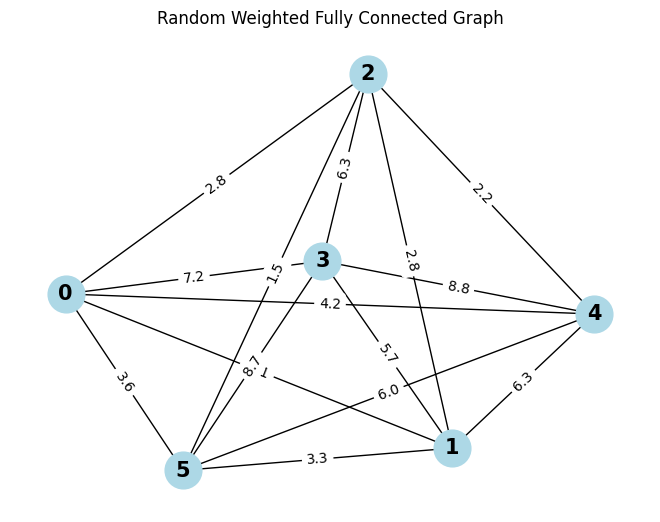

In [29]:
import numpy as np
import cirq
from cirq import ops
from cirq.contrib.svg import SVGCircuit
import networkx as nx
from collections import defaultdict
import cirq_google
import random
import matplotlib.pyplot as plt
import sympy
# 1. 生成一个随机权重的全连接图
def generate_random_weighted_graph(n, weight_range=(1,10)):
    """ 生成一个带有随机权重的全连接图 """
    edges = []
    weights = {}

    # 全连接图的边
    for i in range(n):
        for j in range(i + 1, n):
            # 生成一个随机权重
            #weight = random.uniform(weight_range[0], weight_range[1])
            weight = round(random.uniform(weight_range[0], weight_range[1]), 1)
            edges.append((i, j))
            weights[(i, j)] = weight  # 记录每条边的权重
            weights[(j, i)] = weight  # 图是无向的，权重对称

    return edges, weights

# 示例：生成一个5个节点的全连接图，权重范围为(1, 10)
n = 6
edges, weights = generate_random_weighted_graph(n)
# print("Edges:", edges)
# print("Weights:", weights)
# 2. 绘制随机权重的全连接图
def plot_weighted_graph(n, edges, weights):
    """ 绘制带有随机权重的全连接图 """
    # 创建图
    G = nx.Graph()

    # 添加节点
    G.add_nodes_from(range(n))

    # 添加带权重的边
    for (i, j), weight in weights.items():
        G.add_edge(i, j, weight=weight)

    # 绘制图
    pos = nx.spring_layout(G)  # 使用 spring layout 来安排节点位置
    edge_labels = nx.get_edge_attributes(G, 'weight')  # 获取边的权重

    # 绘制节点和边
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=15, font_weight='bold')

    # 绘制边权重标签
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # 显示图
    plt.title("Random Weighted Fully Connected Graph")
    plt.show()

# 示例：生成一个6个节点的全连接图，权重范围为(1, 10)


# 绘制图
plot_weighted_graph(n, edges, weights)

## 1. Defining a random set of weights over the hardware graph
In order to make the problem easily embeddable on a quantum device, we will look at the problem of Max-Cut on the same graph that the device's qubit connectivity defines, but with random valued edge weights.

Since a circuit covering the entire Sycamore device cannot be easily simulated, a small subset of the device graph will be used instead.

In [30]:
# 2. 构建最大割问题的哈密顿量
def build_max_cut_hamiltonian(n, edges, weights):
    """ 根据图的边和权重构建最大割问题的哈密顿量 """
    pauli_strings = []  # 确保这是一个字典
    qubits = [cirq.LineQubit(i) for i in range(n)]
    for (i, j) in edges:
        weight = weights[(i, j)]
        # 每条边的贡献是 -w * Z_i Z_j，因为 I - Z_i Z_j
        pauli_string=cirq.PauliString({
            qubits[i]: cirq.Z,
            qubits[j]: cirq.Z
        })
        pauli_strings.append((pauli_string, weight))


    # 构造 PauliSum 哈密顿量
    #pauli_sum = cirq.PauliSum.from_pauli_strings(pauli_strings)
    pauli_sum = sum(weight * pauli_string for pauli_string, weight in pauli_strings)
    return pauli_sum
n = 6
edges, weights = generate_random_weighted_graph(n)

# 构建哈密顿量
hamiltonian = build_max_cut_hamiltonian(n, edges, weights)
print("Hamiltonian:", hamiltonian)

Hamiltonian: 5.200*Z(q(0))*Z(q(1))+1.300*Z(q(0))*Z(q(2))+4.200*Z(q(0))*Z(q(3))+3.200*Z(q(0))*Z(q(4))+2.500*Z(q(0))*Z(q(5))+8.400*Z(q(1))*Z(q(2))+8.500*Z(q(1))*Z(q(3))+8.900*Z(q(1))*Z(q(4))+9.600*Z(q(1))*Z(q(5))+7.900*Z(q(2))*Z(q(3))+6.600*Z(q(2))*Z(q(4))+4.300*Z(q(2))*Z(q(5))+7.400*Z(q(3))*Z(q(4))+6.800*Z(q(3))*Z(q(5))+2.700*Z(q(4))*Z(q(5))


## 2. Construct the QAOA circuit
Now that we have created a Max-Cut problem graph, it's time to generate the QAOA circuit following [Farhi et al.](https://arxiv.org/abs/1411.4028). For simplicity, $p = 1$ is chosen.

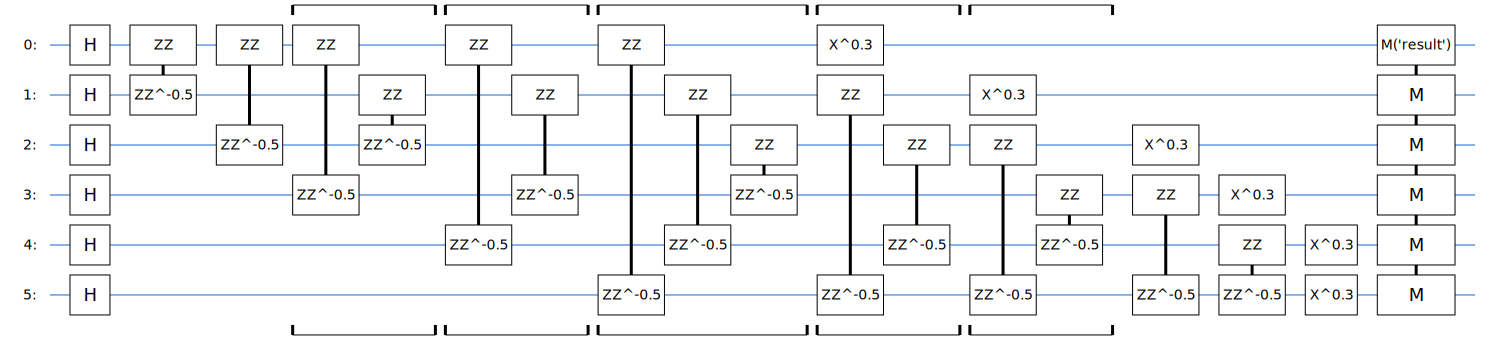

In [31]:
from cirq.contrib.svg import SVGCircuit

# Symbols for the rotation angles in the QAOA circuit.
gamma = sympy.Symbol("gamma")
beta = sympy.Symbol("beta")

# qaoa_circuit = cirq.Circuit(
#     # Prepare uniform superposition on working_qubits == working_graph.nodes
#     cirq.H.on_each(working_graph.nodes()),
#     # Do ZZ operations between neighbors u, v in the graph. Here, u is a qubit,
#     # v is its neighboring qubit, and w is the weight between these qubits.
#      (
#         cirq.ZZ(u, v) ** (alpha * w["weight"])
#         for (u, v, w) in working_graph.edges(data=True)
#     ),#照上述working_graph图连接的方式关联量子线路的（u,v）边

#     # Apply X operations along all nodes of the graph. Again working_graph's
#     # nodes are the working_qubits. Note here we use a moment
#     # which will force all of the gates into the same line.
#     cirq.Moment(cirq.X(qubit) ** beta for qubit in working_graph.nodes()),
#     # All relevant things can be computed in the computational basis.
#     (cirq.measure(qubit) for qubit in working_graph.nodes()),
# )

def qaoa_circuit(n, edges, gamma, beta, p):
    """ 构建QAOA电路 """
    qubits = [cirq.LineQubit(i) for i in range(n)]
    circuit = cirq.Circuit()

    # 初始化量子态
    circuit.append(cirq.H(q) for q in qubits)

    # 添加QAOA电路的层
    for _ in range(p):
        for i, j in edges:
            circuit.append(ops.ZZPowGate(exponent=-gamma).on(qubits[i], qubits[j]))  # 应用成本哈密顿量
        for q in qubits:
            circuit.append(ops.X(q)**beta)  # 应用混合哈密顿量
    # 在所有量子比特上进行测量
    circuit.append(cirq.measure(qubits, key='result'))
    return circuit
gamma=0.5
beta=0.3
p=1
circuit = qaoa_circuit(n, edges, gamma, beta, p)
SVGCircuit(circuit)

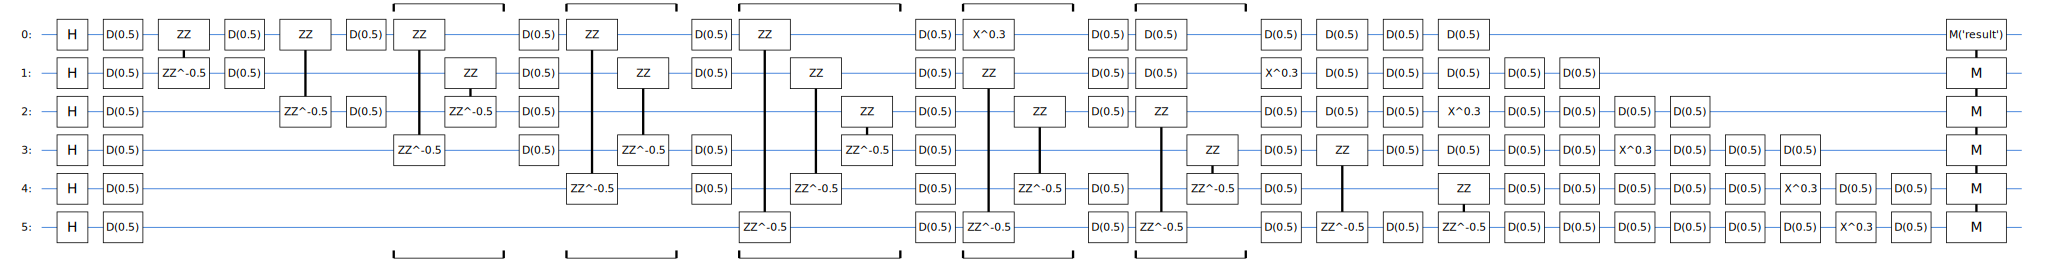

In [32]:
# 添加去极化噪声
def apply_depolarizing_noise(circuit, qubits, prob):
    for qubit in qubits:
        # 在每个量子比特上应用去极化噪声
        circuit.append(cirq.depolarize(prob).on(qubit))
    return circuit

def noise_qaoa_circuit(n, edges, gamma, beta, p,noise_prob):
    """ 构建带噪声的QAOA电路 """
    qubits = [cirq.LineQubit(i) for i in range(n)]
    circuit = cirq.Circuit()
    # 初始化量子态
    circuit.append(cirq.H(q) for q in qubits)
     # 应用噪声
    circuit = apply_depolarizing_noise(circuit, qubits, noise_prob)
    # 添加QAOA电路的层
    for _ in range(p):
        for i, j in edges:
            circuit.append(ops.ZZPowGate(exponent=-gamma).on(qubits[i], qubits[j]))  # 应用成本哈密顿量
            circuit=apply_depolarizing_noise(circuit, [qubits[i], qubits[j]], noise_prob)
        for q in qubits:
            circuit.append(ops.X(q)**beta)  # 应用混合哈密顿量
            circuit = apply_depolarizing_noise(circuit, qubits, noise_prob)
    # 在所有量子比特上进行测量
    circuit.append(cirq.measure(*qubits, key='result'))
    return circuit
gamma=0.5
beta=0.3
p=1
noise_prob=0.5
noise_circuit =noise_qaoa_circuit(n, edges, gamma, beta,p,noise_prob)
SVGCircuit(noise_circuit)

In [33]:
# 5. 设置模拟器和执行电路
def run_qaoa_ideal(n, edges, gamma, beta, p=1, shots=100):
    """ 运行QAOA电路并返回测量结果 """
    qubits = [cirq.LineQubit(i) for i in range(n)]

    # 创建量子电路
    circuit_ideal = qaoa_circuit(n, edges, gamma, beta, p)
    # 创建模拟器运行量子电路
    simulator = cirq.Simulator()
    result_ideal = simulator.run(circuit_ideal, repetitions=shots)

    return result_ideal

print(run_qaoa_ideal(n, edges, gamma, beta, p=1, shots=100))

result=0000011101101110011100011111111010101100001110011100101110111101110111101100100000111100111001100110, 0101111011001101000100110111011010010110000111011000011000100110010001101111000000110010101111010000, 0100100000001010110001000011001111000010000101000010110010110100111001100111011100001011111111011011, 0110100110101001000001100100001010010101110110111100000010111000010011110100101001111110111010101011, 1110101110000000101001010111000010001101110110100100000000110100111011111001110101101110011100110001, 1001000110011010010101011000100111100100001100001011001110001011110101100001100000010111001011000111


In [34]:
# 5. 设置模拟器和执行电路
def run_qaoa_noise(n, edges, gamma, beta, p=1, shots=100):
    """ 运行QAOA电路并返回测量结果 """
    qubits = [cirq.LineQubit(i) for i in range(n)]

    # 创建量子电路
    circuit_noise = noise_qaoa_circuit(n, edges, gamma, beta, p,noise_prob)
    # 创建模拟器运行量子电路
    simulator = cirq.Simulator()
    result_noise = simulator.run(circuit_noise, repetitions=shots)

    return result_noise

print(run_qaoa_noise(n, edges, gamma, beta, p=1, shots=100))

result=1111011111000111110010110011000111001100000111101001001000001001101000100110010111110000011101100111, 1000100000100001001110010101001100101111100100101000111011000001100000101011011010100100100000011011, 1000000000111001111100011010000011110001111000001111101110110101100000010010101010000101100101101011, 0111010100011011100001000101011111011101011000101010000100100001111001111000011011000010110111001011, 0001001101001100001010000001010001011100001111110100001001110110111111000011000100010010011001110001, 0011000101110010011010111100000101101101110001100011010110001000111001110011001001100000101001000011


In [41]:
# 6. 参数优化：通过经典优化来调整gamma和beta
from scipy.optimize import minimize
# 计算切割权重
def compute_cut_weight(state, edges, n):
    cut_weight = 0
    # 确保 state 是二进制字符串
    if isinstance(state, int):
        # 将整数转换为二进制字符串，去掉前缀 '0b'
        state = bin(state)[2:].zfill(n)  # 填充0，使长度与qubits数量一致
    # 遍历所有边
    for i, j in edges:
        # 如果两个节点位于不同的组（即比特串中的值不同），则认为这条边是切割的一部分
        if state[i] != state[j]:
            cut_weight += 1  # 切割的边权重为1，您可以根据实际情况调整权重
    return cut_weight

def optimize_qaoa_ideal(n, edges,gamma, beta, p=1, shots=1000):
    """ 优化QAOA的gamma和beta参数 """
    objective_values = []  # 用于记录每次迭代的目标函数值
    gamma_values = []  # 记录每次迭代的gamma值
    beta_values = []   # 记录每次迭代的beta值
    def objective_function(params):
        gamma, beta = params
        result_ideal_number= run_qaoa_ideal(n, edges, gamma, beta, p, shots)
        counts_i = result_ideal_number.histogram(key='result')
        # 计算目标函数：最大化切割权重
        total_weight = 0
        total_shots = 0
        # 计算每个测量结果的切割权重
        for state, count in counts_i.items():
            # 如果 state 是整数，先转换为二进制字符串
            if isinstance(state, int):
                state = bin(state)[2:].zfill(n)  # 转换为二进制字符串并填充
            # 计算切割的权重
            weight = compute_cut_weight(state, edges, n)
            total_weight += weight * count
            total_shots += count

            total_value=-total_weight / total_shots
            objective_values.append(total_value)
            gamma_values.append(gamma)  # 记录gamma值
            beta_values.append(beta)    # 记录beta值
        # 目标是最大化切割权重，因此返回负的加权切割权重（用于最小化）
        return total_value

    initial_params = np.random.rand(2)  # 随机初始化gamma和beta
    optimizer_ideal = minimize(objective_function, initial_params,method='Nelder-Mead')
    return optimizer_ideal, objective_values, gamma_values, beta_values

    # 返回优化结果和目标函数值的变化

optimizer_ideal, objective_values, gamma_values, beta_values = optimize_qaoa_ideal(n, edges, gamma, beta, p=1, shots=100)
print(optimizer_ideal)
print(objective_values)
print(gamma_values)
print(beta_values)


       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: -8.9
             x: [ 5.171e-01  1.151e-01]
           nit: 141
          nfev: 400
 final_simplex: (array([[ 5.171e-01,  1.151e-01],
                       [ 5.171e-01,  1.151e-01],
                       [ 5.171e-01,  1.151e-01]]), array([-8.900e+00, -7.800e+00, -7.400e+00]))
[-5.0, -7.0, -6.333333333333333, -5.8, -6.333333333333333, -6.142857142857143, -6.5, -6.777777777777778, -7.0, -5.0, -5.0, -6.333333333333333, -5.8, -5.666666666666667, -6.142857142857143, -6.5, -6.777777777777778, -7.0, -5.0, -7.0, -8.0, -8.333333333333334, -8.428571428571429, -8.0, -8.11111111111111, -7.8, -9.0, -7.0, -8.2, -7.666666666666667, -7.0, -7.222222222222222, -7.0, -9.0, -7.0, -6.333333333333333, -6.0, -7.0, -7.285714285714286, -7.5, -7.222222222222222, -7.4, -5.0, -5.0, -5.0, -4.0, -4.833333333333333, -5.428571428571429, -5.375, -5.777777777777778, -5.2, -9.0, -9.0, -9.0

In [42]:
# 6. 参数优化：通过经典优化来调整gamma和beta
from scipy.optimize import minimize

def optimize_qaoa_noise(n, edges,gamma, beta, p=1, shots=1000):
    """ 优化含噪QAOA的gamma和beta参数 """
    objective_values_noise = []  # 用于记录每次迭代的目标函数值
    gamma_values_noise= []  # 记录每次迭代的gamma值
    beta_values_noise= []   # 记录每次迭代的beta值
    def objective_function_noise(params):
        gamma, beta = params
        result_noise_number= run_qaoa_noise(n, edges, gamma, beta, p, shots)
        counts_n = result_noise_number.histogram(key='result')
        # 计算目标函数：最大化切割权重
        total_weight = 0
        total_shots = 0
        # 计算每个测量结果的切割权重
        for state, count in counts_n.items():
            # 如果 state 是整数，先转换为二进制字符串
            if isinstance(state, int):
                state = bin(state)[2:].zfill(n)  # 转换为二进制字符串并填充
            # 计算切割的权重
            weight = compute_cut_weight(state, edges, n)
            total_weight += weight * count
            total_shots += count
            gamma_values_noise.append(gamma)  # 记录gamma值
            beta_values_noise.append(beta)    # 记录beta值
            total_value_noise=-total_weight / total_shots
            objective_values_noise.append(total_value_noise)
        # 目标是最大化切割权重，因此返回负的加权切割权重（用于最小化）
        return total_value_noise

    initial_params = np.random.rand(2)  # 随机初始化gamma和beta
    optimizer_noise = minimize(objective_function_noise, initial_params,method='Nelder-Mead')
    return optimizer_noise, objective_values_noise, gamma_values_noise, beta_values_noise

    # 返回优化结果和目标函数值的变化

optimizer_noise, objective_values_noise, gamma_values_noise, beta_values_noise = optimize_qaoa_noise(n, edges, gamma, beta, p=1, shots=10)
print(optimizer_noise)
print(objective_values_noise)
print(gamma_values_noise)
print(beta_values_noise)

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: -8.7
             x: [ 1.021e+00  5.851e-01]
           nit: 148
          nfev: 400
 final_simplex: (array([[ 1.021e+00,  5.851e-01],
                       [ 1.021e+00,  5.851e-01],
                       [ 1.021e+00,  5.851e-01]]), array([-8.700e+00, -8.200e+00, -8.000e+00]))
[-8.0, -8.0, -7.0, -6.5, -6.8, -6.5, -6.285714285714286, -6.5, -6.666666666666667, -6.0, -8.0, -8.5, -8.333333333333334, -7.5, -7.0, -7.166666666666667, -7.428571428571429, -7.5, -7.222222222222222, -7.3, -9.0, -8.666666666666666, -8.5, -8.6, -7.166666666666667, -6.857142857142857, -7.0, -7.111111111111111, -7.2, -9.0, -8.333333333333334, -7.5, -7.8, -7.833333333333333, -8.0, -7.0, -6.777777777777778, -6.9, -8.0, -8.0, -8.333333333333334, -8.25, -7.6, -7.666666666666667, -8.0, -8.0, -8.0, 0.0, -4.0, -5.666666666666667, -6.25, -6.6, -6.333333333333333, -6.714285714285714, -7.0, -6.8, 

Optimized parameters (gamma, beta): [0.51707331 0.11507766]
Final ideal objective value: -8.9
Optimized parameters (gamma, beta): [1.02105412 0.58514885]
Final noise objective value: -8.7


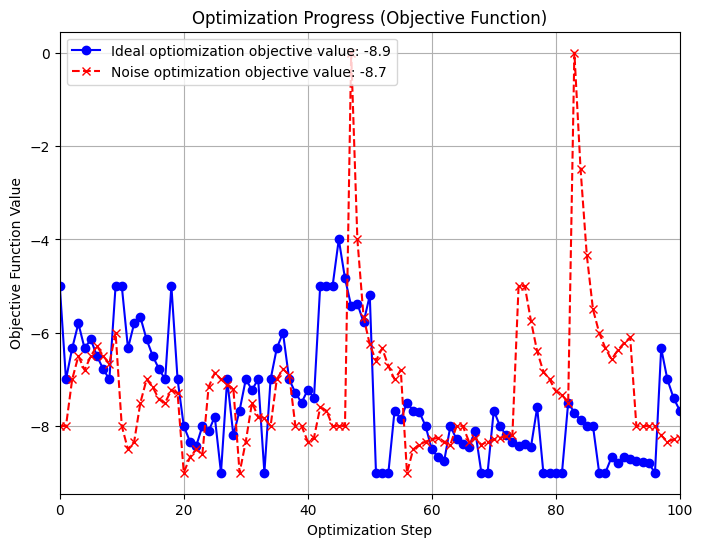

<Figure size 640x480 with 0 Axes>

In [51]:
# 打印优化结果
print("Optimized parameters (gamma, beta):", optimizer_ideal.x)
print("Final ideal objective value:", optimizer_ideal.fun)
print("Optimized parameters (gamma, beta):", optimizer_noise.x)
print("Final noise objective value:", optimizer_noise.fun)
# 绘制目标函数值变化
# plt.subplot(1, 2, 1)
plt.figure(figsize=(8, 6))
# 设置x轴的区间：从0到目标函数值的迭代次数
plt.xlim(0, 100)  # 设置x轴区间
plt.plot(objective_values,label="Ideal optiomization objective value: -8.9" ,color='blue', linestyle='-', marker='o')
plt.plot(objective_values_noise,label="Noise optimization objective value: -8.7", color='red', linestyle='--', marker='x')
plt.xlabel("Optimization Step")
plt.ylabel("Objective Function Value")
plt.title("Optimization Progress (Objective Function)")
plt.grid(True)
plt.legend()
plt.show()
# 保存图片为 PNG 格式
plt.savefig('objective_function_plot.png')  #损失函数应该是越小越好

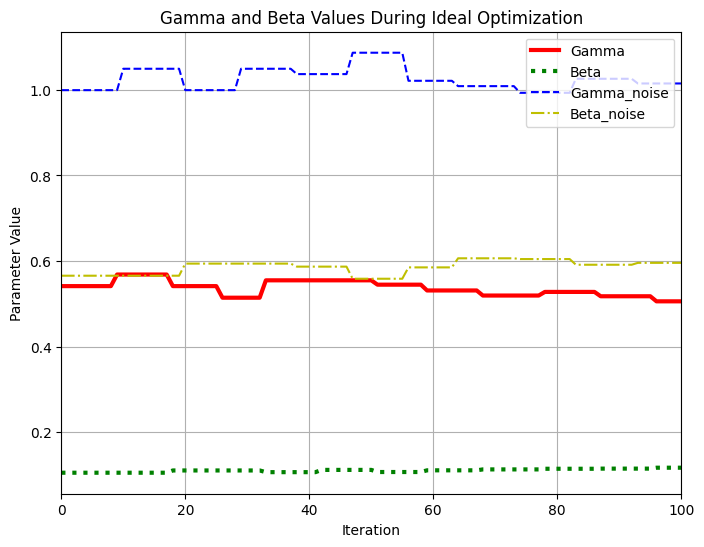

In [53]:
# 绘制gamma和beta值变化
plt.figure(figsize=(8, 6))

plt.plot(gamma_values, label="Gamma", color="r", linestyle='-',  markersize=5, linewidth=3)
plt.plot(beta_values, label="Beta", color="g", linestyle=':',  markersize=5, linewidth=3)
plt.plot(gamma_values_noise, label="Gamma_noise", color="b", linestyle='--',  markersize=5, linewidth=1.5)
plt.plot(beta_values_noise, label="Beta_noise", color="y", linestyle='-.',  markersize=5, linewidth=1.5)
plt.title('Gamma and Beta Values During Ideal Optimization')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')

# 设置x轴的区间：从0到gamma和beta的迭代次数
plt.xlim(0, 100)  # 设置x轴区间
plt.grid(True)
plt.legend(loc='upper right')

# 保存图片为 PNG 格式
plt.savefig('gamma_beta_plot_ideal.png')  # 你可以指定保存路径，如 './plots/gamma_beta_plot.png'

# 显示图形
plt.show()

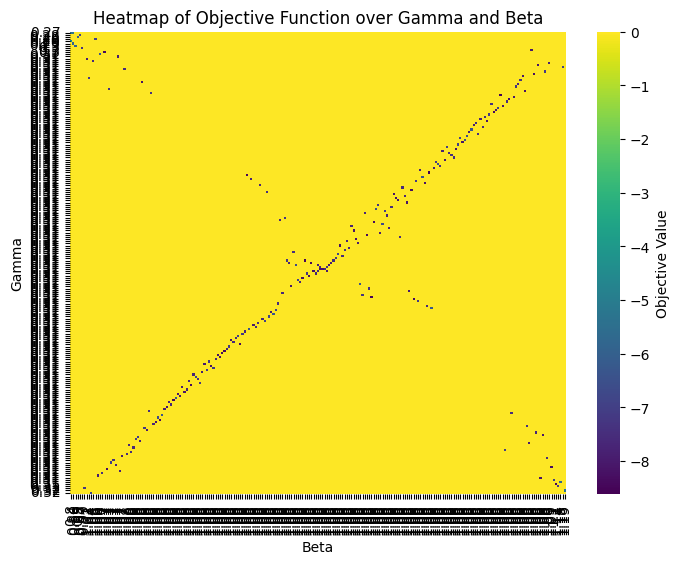

In [19]:
import seaborn as sns
# 将gamma_values和beta_values转换为二维数组
# 首先找到gamma和beta的独特值范围
gamma_unique = np.unique(gamma_values)
beta_unique = np.unique(beta_values)
# 创建一个网格，用于存储目标函数值
Z = np.zeros((len(gamma_unique), len(beta_unique)))
# 填充Z数组
for i, gamma in enumerate(gamma_unique):
    for j, beta in enumerate(beta_unique):
        # 查找对应的目标函数值
        # 对应的gamma和beta组合的目标函数值
        idx = [(g == gamma and b == beta) for g, b in zip(gamma_values, beta_values)]
        if np.any(idx):  # 确保至少有一个匹配
            Z[i, j] = np.mean([objective_values[k] for k in range(len(objective_values)) if idx[k]])

# 绘制gamma和beta的热力图
plt.figure(figsize=(8, 6))
# 设置x轴的区间：从0到gamma和beta的迭代次数
plt.xlim(-0.5, len(beta_unique) - 0.5)  # 设置x轴区间
plt.ylim(len(gamma_unique) - 0.5, -0.5)  # 设置y轴区间
sns.heatmap(Z, xticklabels=np.round(beta_unique, 2), yticklabels=np.round(gamma_unique, 2), cmap='viridis', cbar_kws={'label': 'Objective Value'})
plt.title('Heatmap of Objective Function over Gamma and Beta')
plt.xlabel('Beta')
plt.ylabel('Gamma')
plt.show()

Ideal optimized parameters: Gamma = 0.5170733118870958, Beta = 0.11507766299734506
Noise optimized parameters: Gamma_n = 1.02105411914415, Beta_n = 0.5851488499917948
Measurement counts: Counter({35: 7, 16: 6, 55: 5, 31: 4, 61: 4, 21: 4, 7: 4, 8: 4, 44: 4, 52: 4, 50: 4, 41: 3, 14: 3, 47: 3, 56: 3, 38: 3, 4: 3, 42: 3, 11: 3, 22: 3, 25: 3, 28: 3, 2: 2, 59: 2, 49: 2, 1: 2, 62: 2, 19: 2, 26: 1, 32: 1, 23: 1, 37: 1, 13: 1})


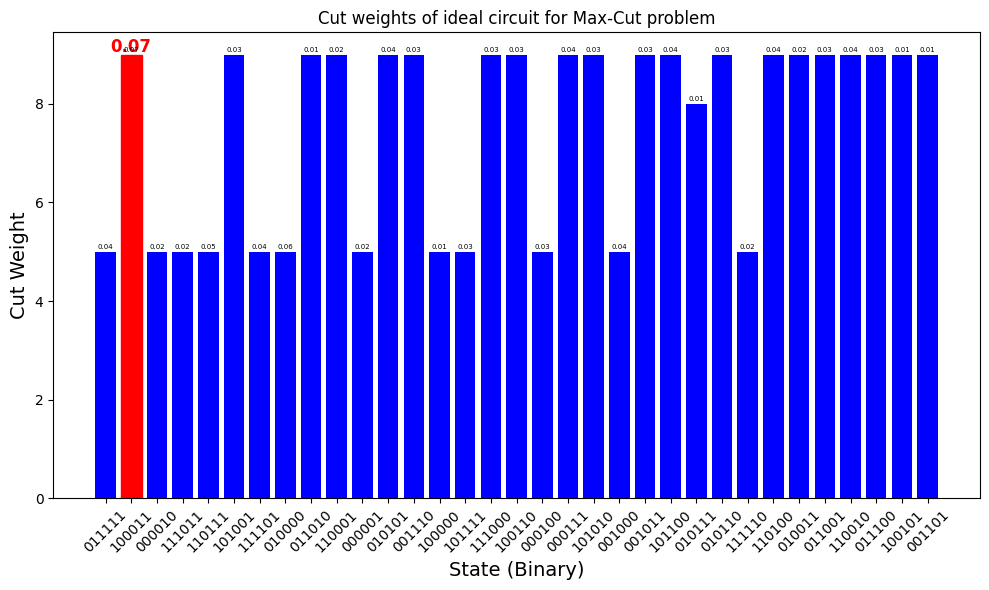

In [61]:
#理想线路最终输出
# 调用优化函数
optimal_gamma, optimal_beta=optimizer_ideal.x
optimal_gamma_noise, optimal_beta_noise=optimizer_noise.x
print(f"Ideal optimized parameters: Gamma = {optimal_gamma}, Beta = {optimal_beta}")
print(f"Noise optimized parameters: Gamma_n = {optimal_gamma_noise}, Beta_n = {optimal_beta_noise}")
circuit_ideal_final = run_qaoa_ideal(n, edges, optimal_gamma, optimal_beta, p)
result=run_qaoa_ideal(n, edges, optimal_gamma, optimal_beta, p)
# 获取并打印测量结果
counts = result.histogram(key='result')
print("Measurement counts:", counts)
# 计算每个测量结果的切割权重
cut_weights = {bin(state)[2:].zfill(n): compute_cut_weight(bin(state)[2:].zfill(n), edges, n) for state in counts.keys()}
# 5. 计算每个切割结果的概率
total_shots = sum(counts.values())
probabilities = {bin(state)[2:].zfill(n): count / total_shots for state, count in counts.items()}


# 6. 找到最大割的状态（切割权重最大）
max_cut_state = max(cut_weights, key=cut_weights.get)
max_cut_weight = cut_weights[max_cut_state]
max_cut_probability = probabilities[max_cut_state]

# 绘制柱状图
states = list(cut_weights.keys())
weights = list(cut_weights.values())
probs = [probabilities[state] for state in states]  # 对应的概率

plt.figure(figsize=(10, 6))
bars=plt.bar(states, weights, color='b')
# 8. 用红色标注最大割
for i, bar in enumerate(bars):
    if states[i] == max_cut_state:
        bar.set_color('r')  # 设置最大割的条形图为红色
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
                 f'{max_cut_probability:.2f}', ha='center', color='red', fontsize=12, fontweight='bold')

plt.title('Cut weights of ideal circuit for Max-Cut problem')
plt.xlabel('State (Binary)', fontsize=14)
plt.ylabel('Cut Weight', fontsize=14)

# 显示概率
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
             f'{probs[i]:.2f}', ha='center', color='black', fontsize=5)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Ideal optimized parameters: Gamma = 0.5170733118870958, Beta = 0.11507766299734506
Noise optimized parameters: Gamma_n = 1.02105411914415, Beta_n = 0.5851488499917948
Measurement counts: Counter({24: 5, 63: 4, 48: 4, 23: 3, 62: 3, 6: 3, 51: 3, 50: 3, 8: 3, 15: 3, 49: 3, 39: 3, 2: 2, 12: 2, 9: 2, 4: 2, 52: 2, 10: 2, 36: 2, 41: 2, 54: 2, 43: 2, 3: 2, 18: 2, 21: 2, 33: 2, 28: 2, 34: 2, 14: 2, 53: 2, 16: 2, 29: 2, 37: 1, 22: 1, 32: 1, 30: 1, 20: 1, 11: 1, 45: 1, 55: 1, 0: 1, 38: 1, 25: 1, 27: 1, 19: 1, 40: 1, 42: 1, 26: 1, 35: 1, 58: 1, 44: 1, 57: 1})


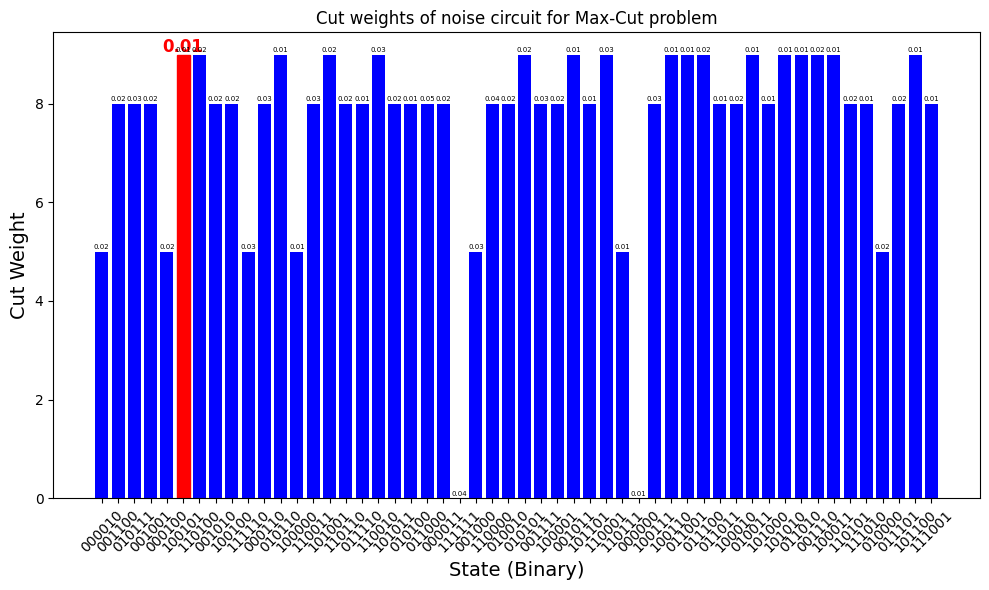

In [69]:

# 调用优化函数
optimal_gamma, optimal_beta=optimizer_ideal.x
optimal_gamma_noise, optimal_beta_noise=optimizer_noise.x
print(f"Ideal optimized parameters: Gamma = {optimal_gamma}, Beta = {optimal_beta}")
print(f"Noise optimized parameters: Gamma_n = {optimal_gamma_noise}, Beta_n = {optimal_beta_noise}")
result2=run_qaoa_noise(n, edges, optimal_gamma, optimal_beta, p)
# 获取并打印测量结果
counts = result2.histogram(key='result')
print("Measurement counts:", counts)
# 计算每个测量结果的切割权重
cut_weights = {bin(state)[2:].zfill(n): compute_cut_weight(bin(state)[2:].zfill(n), edges, n) for state in counts.keys()}
# 5. 计算每个切割结果的概率
total_shots = sum(counts.values())
probabilities = {bin(state)[2:].zfill(n): count / total_shots for state, count in counts.items()}


# 6. 找到最大割的状态（切割权重最大）
max_cut_state = max(cut_weights, key=cut_weights.get)
max_cut_weight = cut_weights[max_cut_state]
max_cut_probability = probabilities[max_cut_state]

# 绘制柱状图
states = list(cut_weights.keys())
weights = list(cut_weights.values())
probs = [probabilities[state] for state in states]  # 对应的概率

plt.figure(figsize=(10, 6))
bars=plt.bar(states, weights, color='b')
# 8. 用红色标注最大割
for i, bar in enumerate(bars):
    if states[i] == max_cut_state:
        bar.set_color('r')  # 设置最大割的条形图为红色
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
                 f'{max_cut_probability:.2f}', ha='center', color='red', fontsize=12, fontweight='bold')

plt.title('Cut weights of noise circuit for Max-Cut problem')
plt.xlabel('State (Binary)', fontsize=14)
plt.ylabel('Cut Weight', fontsize=14)

# 显示概率
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
             f'{probs[i]:.2f}', ha='center', color='black', fontsize=5)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Compare cuts

We now compare the optimal cut found by QAOA to a randomly selected cut. The helper function draws the `working_graph` and colors nodes in different sets different colors. Additionally, we print out the cost function for the given cut.

In [ ]:
def output_cut(s_partition: List[cirq.Qid]) -> None:
    """Plot and output the graph cut information."""
    #打印指定图的最大割值，网格节点是否在指定分区采用两种不同着色区分,s_partition为蓝色，t_partition为红色
    # Generate the colors.
    coloring = []
    for node in working_graph:
        if node in s_partition:
            coloring.append("blue")
        else:
            coloring.append("red")

    # Get the weights
    edges = working_graph.edges(data=True)
    weights = [w["weight"] for (u, v, w) in edges]

    nx.draw_circular(
        working_graph,
        node_color=coloring,
        node_size=1000,
        with_labels=True,
        width=weights,
    )
    plt.show()#绘制为分区之前的图
    size = nx.cut_size(working_graph, s_partition, weight="weight")
    print(f"Cut size: {size}")

As an example, we can test this function with all nodes in the same set, for which the cut size should be zero.

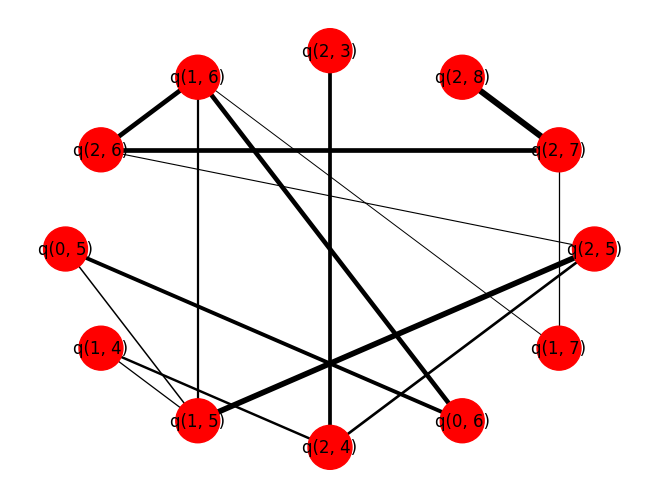

Cut size: 0


In [ ]:
# Test with the empty S and all nodes placed in T.
output_cut([])

To get cuts using the QAOA we will first need to extract the best control parameters found during the sweep:

In [ ]:
best_exp_index = np.unravel_index(np.argmax(exp_values), exp_values.shape)
#获取exp_values期望值最大值5.943535e+00的索引在一维数组中的位置
print(best_exp_index, type(best_exp_index))
best_parameters = par_values[best_exp_index]
print(f"Best control parameters: {best_parameters}")

(15, 19) <class 'tuple'>
Best control parameters: [4.96040945 6.28318531]


In [ ]:
print(exp_values)

[[ 1.575000e-03  5.518200e-02  3.297700e-02  1.266220e-01 -6.001700e-02
  -5.750200e-02  8.556600e-02  2.181000e-03  6.000800e-02  2.899600e-02
  -3.327400e-02  2.155000e-03 -9.381000e-03  6.211600e-02  1.572120e-01
  -2.330400e-02 -1.044620e-01  5.432800e-02  1.732970e-01  1.336000e-02]
 [-7.432000e-02 -2.172927e+00  2.249966e+00  9.952100e-02 -2.302939e+00
   1.943153e+00  2.173670e-01 -2.208303e+00  1.988364e+00  3.448170e-01
  -2.389936e+00  1.947240e+00  5.278540e-01 -2.305943e+00  1.830232e+00
   6.627250e-01 -2.476516e+00  1.779070e+00  8.325590e-01 -2.400243e+00]
 [-3.854700e-02 -2.819000e-02  2.228010e-01  1.299600e-01 -1.356450e-01
   3.919900e-02 -4.884500e-02  3.930100e-02  1.759170e-01  2.804600e-02
  -9.048800e-02  1.987100e-02 -7.499200e-02 -1.923360e-01 -3.903400e-02
  -2.046400e-02 -1.003100e-02  1.247850e-01 -6.594500e-02 -2.611100e-02]
 [ 1.428500e-02 -3.668051e+00  3.591348e+00  3.369340e-01 -3.903101e+00
   3.564950e+00  3.606910e-01 -3.856883e+00  3.486752e+00  6.

In [ ]:
print(best_parameters)

[4.96040945 6.28318531]


Each bitstring can be seen as a candidate cut in the graph. The qubits that measured 0 correspond to that qubit being in one cut partition and a qubit that measured to 1 corresponds to that qubit being in the other cut partition. Now that we've found good parameters for the `qaoa_circuit`, we can just sample some bistrings, iterate over them and pick the one that gives the best cut:

In [ ]:
# Number of candidate cuts to sample.
num_cuts = 100
candidate_cuts = sim.sample(
    qaoa_circuit,
    params={alpha: best_parameters[0], beta: best_parameters[1]},
    repetitions=num_cuts,
)
#每个采样位串都可以看作是图中的候选切割
#采样100次，根据best_parameters的取值作为最优参数，求最大割问题
# Variables to store best cut partitions and cut size.
best_qaoa_S_partition = set()
best_qaoa_T_partition = set()
best_qaoa_cut_size = -np.inf#无无限数

# Analyze each candidate cut.
for i in range(num_cuts):
    candidate = candidate_cuts.iloc[i]
    one_qubits = set(candidate[candidate == 1].index)
    S_partition = set()
    T_partition = set()
    for node in working_graph:
        if str(node) in one_qubits:#照图节点更新分区
            # If a one was measured add node to S partition.value=1
            S_partition.add(node)
        else:
            # Otherwise a zero was measured so add to T partition.value=0
            T_partition.add(node)

    cut_size = nx.cut_size(working_graph, S_partition, T_partition, weight="weight")
    #添加新节点到分区后将获得一个新割值
    # If you found a better cut update best_qaoa_cut variables.
    if cut_size > best_qaoa_cut_size:
        best_qaoa_cut_size = cut_size
        best_qaoa_S_partition = S_partition
        best_qaoa_T_partition = T_partition

In [ ]:
print(one_qubits)
print(candidate)#初始解

{'q(2, 8)', 'q(2, 6)', 'q(0, 5)', 'q(1, 7)', 'q(1, 5)', 'q(2, 4)', 'q(1, 6)', 'q(2, 3)', 'q(2, 5)'}
alpha      4.960409
beta       6.283185
q(2, 5)    1.000000
q(2, 7)    0.000000
q(2, 8)    1.000000
q(2, 3)    1.000000
q(1, 6)    1.000000
q(2, 6)    1.000000
q(0, 5)    1.000000
q(1, 4)    0.000000
q(1, 5)    1.000000
q(2, 4)    1.000000
q(0, 6)    0.000000
q(1, 7)    1.000000
Name: 99, dtype: float64


The QAOA is known to do just a little better than random guessing for Max-Cut on 3-regular graphs at `p=1`. You can use very similar logic to the code above, but now instead of relying on the QAOA to decide your `S_partition` and `T_partition` you can just pick then randomly:

In [ ]:
import random
#没有采用QAOA，而是依据随机猜测来制定分区
best_random_S_partition = set()
best_random_T_partition = set()
best_random_cut_size = -9999

# Randomly build candidate sets.
for i in range(num_cuts):
    S_partition = set()
    T_partition = set()
    for node in working_graph:
        if random.random() > 0.5:#随机猜测添加分区
            # If we flip heads add to S.
            S_partition.add(node)
        else:
            # Otherwise add to T.
            T_partition.add(node)

    cut_size = nx.cut_size(working_graph, S_partition, T_partition, weight="weight")

    # If you found a better cut update best_random_cut variables.
    if cut_size > best_random_cut_size:
        best_random_cut_size = cut_size
        best_random_S_partition = S_partition
        best_random_T_partition = T_partition

In [ ]:
print(best_random_cut_size)

28.540000000000003


-----QAOA-----


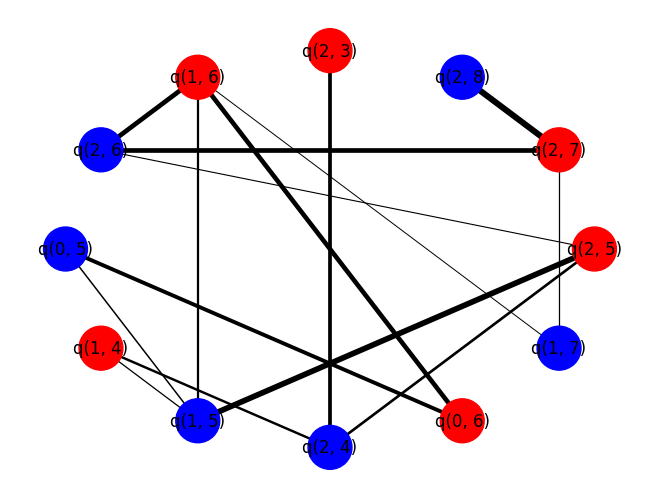

Cut size: 29.340000000000007


-----RANDOM-----


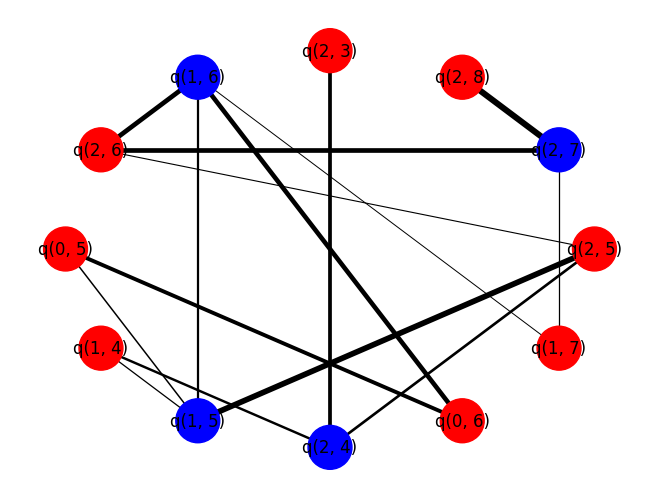

Cut size: 28.540000000000003


In [ ]:
print("-----QAOA-----")
output_cut(best_qaoa_S_partition)

print("\n\n-----RANDOM-----")
output_cut(best_random_S_partition)

For this problem instance, one should see that $p = 1$ QAOA performs better, on average, than randomly guessing.